<a href="https://colab.research.google.com/github/DavidGTeklea/BigIdeasFinal/blob/main/OL_Hotel_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.6 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"davidteklea","key":"6979f4292245affec7e1edf13a2bb74f"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [4]:
!pip install kaggle
!kaggle datasets download -d jessemostipak/hotel-booking-demand -p data/
!unzip data/hotel-booking-demand.zip -d data/


Dataset URL: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 704MB/s]
Archive:  data/hotel-booking-demand.zip
  inflating: data/hotel_bookings.csv  


In [5]:
import os, random, numpy as np, torch
def set_seed(s=2025):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
set_seed(2025)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# ================================================================
# Individual Time-Aware Split → Shared Preprocess
# (low-card OHE, high-card CountEncoding, StandardScaler, float32)
# ================================================================
# python >=3.10
# pip install scikit-learn>=1.2 category-encoders pandas numpy joblib matplotlib
from torch.utils.data import TensorDataset, DataLoader

import os, time, pathlib, multiprocessing as mp
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import category_encoders as ce
from joblib import Memory

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import TruncatedSVD


# ---------- CPU settings ----------
NJOBS = min(2, mp.cpu_count() or 2)
os.environ["OMP_NUM_THREADS"] = str(NJOBS)
os.environ["OPENBLAS_NUM_THREADS"] = str(NJOBS)
os.environ["MKL_NUM_THREADS"] = str(NJOBS)
os.environ["NUMEXPR_NUM_THREADS"] = str(NJOBS)

# ---------- Config ----------
CSV_PATH   = "data/hotel_bookings.csv"
TARGET     = "is_canceled"
TIME_COL   = "_t"                  # helper booking timestamp (for splitting only)
TEST_SIZE  = 0.20
SEED_SPLIT = 2025

# leakage drops (at-booking model)
DROP_ALWAYS = ["reservation_status", "reservation_status_date"]
# You can add more here later after EDA:
DROP_OPTIONAL = []  # e.g., ["booking_changes","days_in_waiting_list"]

# high-cardinality cutoff and encoder settings
HICARD_THRESH = 50
COUNT_NORMALIZE = True  # frequency (0..1)

# output/cache
BASE_OUT = pathlib.Path("results/shared_pipeline_time_individual")
BASE_OUT.mkdir(parents=True, exist_ok=True)
CACHE_DIR = pathlib.Path("cache_shared")
CACHE_DIR.mkdir(exist_ok=True)
memory = Memory(location=str(CACHE_DIR), verbose=0)

# ---------- Load ----------
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=[c for c in DROP_ALWAYS + DROP_OPTIONAL if c in df.columns]).copy()

# ---------- Build booking_time = arrival_date - lead_time ----------
def build_booking_time(d: pd.DataFrame) -> pd.Series:
    # robust to month names
    arr = pd.to_datetime(
        d["arrival_date_year"].astype(str) + "-" +
        d["arrival_date_month"].astype(str) + "-" +
        d["arrival_date_day_of_month"].astype(str),
        errors="coerce"
    )
    lead = pd.to_timedelta(d["lead_time"].fillna(0).astype(int), unit="D")
    t = arr - lead                               # booking time (at booking)
    if t.isna().all():
        t = arr                                  # fallback to arrival
    t = t.fillna(t.dropna().min())               # fill any remaining NaT
    return t


df[TIME_COL] = build_booking_time(df)
min_ts = df[TIME_COL].dropna().min()
df[TIME_COL] = df[TIME_COL].fillna(min_ts)


# Add after df[TIME_COL] is created:
X = df.drop(columns=[TARGET])
y = df[TARGET].values
# Time-based split
split_time = X[TIME_COL].quantile(1 - TEST_SIZE)
train_mask = X[TIME_COL] <= split_time
X_train = X[train_mask].copy()
X_test = X[~train_mask].copy()
y_train = y[train_mask]
y_test = y[~train_mask]
w_train = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
# ---------- Sort TRAIN chronologically for TimeSeriesSplit ----------


ord_tr = X_train[TIME_COL].argsort(kind="mergesort")
X_train = X_train.iloc[ord_tr].reset_index(drop=True)
y_train = y_train[ord_tr]
w_train = w_train[ord_tr]



# ================================================================
# Shared preprocessing
#  - Exclude TIME_COL from features (split helper; seasonality should come from arrival parts)
#  - numeric: impute → (global) StandardScaler(with_mean=False)
#  - categorical low-card: OHE (sparse)
#  - categorical high-card: CountEncoder (dense) → CSR
#  - cast to float32
# ================================================================
def dense_to_csr(X):
    if sp.issparse(X): return X.tocsr()
    return sp.csr_matrix(X)

def to_dense(X):
    import numpy as np, scipy.sparse as sp
    return X.toarray() if sp.issparse(X) else np.asarray(X)

def to_float32(X):
    import numpy as np, scipy.sparse as sp
    if sp.issparse(X): return X.astype(np.float32)
    return np.asarray(X, dtype=np.float32, copy=False)

def make_shared_preprocess(X_frame: pd.DataFrame, memory=None):
    Xf = X_frame.drop(columns=[TIME_COL], errors="ignore")
    cat_cols = [c for c in Xf.columns if Xf[c].dtype == "object"]
    num_cols = [c for c in Xf.columns if c not in cat_cols]

    nunique = {c: Xf[c].nunique(dropna=True) for c in cat_cols}
    cat_low = [c for c in cat_cols if nunique[c] <= HICARD_THRESH]
    cat_hi  = [c for c in cat_cols if nunique[c] >  HICARD_THRESH]

    num_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler()),
    ], memory=memory)  # <- no caching

    low_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore",
                              sparse_output=True, dtype=np.float32)),
    ], memory=memory)  # <- no caching

    # No csr step; keep it dense here, union stays sparse due to OHE + sparse_threshold
    hi_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("cnt", ce.CountEncoder(normalize=COUNT_NORMALIZE)),
        ("sc",  StandardScaler()),
    ], memory=memory)  # <- no caching

    preprocess = ColumnTransformer([
        ("num",     num_pipe, num_cols),
        ("cat_low", low_pipe, cat_low),
        ("cat_hi",  hi_pipe,  cat_hi),
    ], remainder="drop", sparse_threshold=1.0, n_jobs=None)  # <- no n_jobs inside

    shared = Pipeline([
        ("prep",  preprocess),
        ("fp32",  FunctionTransformer(to_float32, accept_sparse=True, validate=False)),
    ], memory=memory)  # <- no caching

    return shared

def add_densify(shared_pipeline):
    steps = list(shared_pipeline.steps) + [
        ("dense", FunctionTransformer(to_dense, accept_sparse=True, validate=False)),
        ("fp32b", FunctionTransformer(to_float32, accept_sparse=False, validate=False)),
    ]
    return Pipeline(steps, memory=memory)  # <- no caching

shared_pre = make_shared_preprocess(X_train, memory)

# 1) Fit a *throwaway* copy of your preprocessor just to read its width. for rbf
tmp_pre = make_shared_preprocess(X_train)
tmp_pre.fit(X_train)                           # train-split only; no leakage to test
d = tmp_pre.transform(X_train.iloc[:1]).shape[1]
print(d)


# ---------- Time-aware CV (individual, forward-chaining) ----------
INNER_SPLITS = 3
INNER_CV = TimeSeriesSplit(n_splits=INNER_SPLITS)



import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix

def choose_threshold_max_f1(y_true, scores, pos_label=1):
    """Return t*, best_F1, precision_at_t*, recall_at_t* using decision_function scores."""
    P, R, T = precision_recall_curve(y_true, scores, pos_label=pos_label)
    # precision_recall_curve returns len(T) = len(P) - 1 = len(R) - 1
    f1 = 2 * P[1:] * R[1:] / (P[1:] + R[1:] + 1e-12)
    i = np.nanargmax(f1)
    return T[i], float(f1[i]), float(P[i+1]), float(R[i+1])

def apply_threshold(scores, t_star):
    return (scores >= t_star).astype(int)

TAUS = globals().get("TAUS", {})



81


In [7]:
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 3.8 MB/s eta 0:00:00


In [8]:
# 1) Make a chronological validation split *inside your training period*
VAL_SIZE = 0.20
cut = X_train[TIME_COL].quantile(1 - VAL_SIZE)

tr_mask  = X_train[TIME_COL] <= cut      # earlier 80% -> model-fitting "train"
val_mask = ~tr_mask                      # later 20%  -> fixed "validation"

X_tr_df  = X_train.loc[tr_mask].copy()
y_tr     = y_train[tr_mask]
X_val_df = X_train.loc[val_mask].copy()
y_val    = y_train[val_mask]

# 2) Fit your existing preprocessor on TRAIN ONLY (no leakage)
shared_pre = make_shared_preprocess(X_tr_df, memory=None)
shared_pre.fit(X_tr_df)                  # <— this is what I meant by "shared_pre_fit"

# 3) Transform to numpy (float32). If sparse, densify before tensors.
import numpy as np, scipy.sparse as sp
def to_dense_np(X):
    return X.toarray().astype(np.float32) if sp.issparse(X) else np.asarray(X, np.float32)

X_tr_np  = to_dense_np(shared_pre.transform(X_tr_df))
X_val_np = to_dense_np(shared_pre.transform(X_val_df))
X_te_np  = to_dense_np(shared_pre.transform(X_test.copy()))
y_tr_np  = y_tr.astype(np.float32)
y_val_np = y_val.astype(np.float32)
y_te_np  = y_test.astype(np.float32)

tr = torch.from_numpy(X_tr_np).float();
ytr = torch.from_numpy(y_tr_np).float();

# --- continue from your last line ---
import torch
from torch.utils.data import TensorDataset, DataLoader

# 4) Convert to tensors (binary classification → float targets)
Xtr_t  = torch.from_numpy(X_tr_np).float()
Xval_t = torch.from_numpy(X_val_np).float()
Xte_t  = torch.from_numpy(X_te_np).float()

ytr_t  = torch.from_numpy(y_tr_np).float()   # 0/1 as float for BCEWithLogitsLoss
yval_t = torch.from_numpy(y_val_np).float()
yte_t  = torch.from_numpy(y_te_np).float()

# 5) Wrap into datasets/loaders (shuffle only on training)
train_loader = DataLoader(TensorDataset(Xtr_t,  ytr_t),  batch_size=256,  shuffle=True,  drop_last=False)
val_loader   = DataLoader(TensorDataset(Xval_t, yval_t), batch_size=1024, shuffle=False)
test_loader  = DataLoader(TensorDataset(Xte_t,  yte_t),  batch_size=1024, shuffle=False)

# --- quick sanity checks (optional) ---
xb, yb = next(iter(train_loader))
print("Train batch:", xb.shape, yb.shape, xb.dtype, yb.dtype)  # e.g., [256, d], [256]
print("Val size:", len(val_loader.dataset), "Test size:", len(test_loader.dataset))



Train batch: torch.Size([256, 81]) torch.Size([256]) torch.float32 torch.float32
Val size: 19108 Test size: 23703


In [9]:
# ===================== MLP (skorch, SGD) — Halving v2 (balanced, faster learning) ===================== #with treshold
import numpy as np, torch, torch.nn as nn
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve  # <- added PRC
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV, TimeSeriesSplit
from sklearn.base import clone  # <- added
from skorch import NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping

# imbalance weight (pos_weight = neg/pos)
pos = float((y_train == 1).sum())
neg = float((y_train == 0).sum())
pos_weight = torch.tensor([neg / max(pos, 1.0)], dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self, hidden=(512, 512), dropout=0.0):
        super().__init__()
        layers, lazy, prev = [], True, None
        for h in hidden:
            layers += [nn.LazyLinear(h) if lazy else nn.Linear(prev, h), nn.ReLU()]
            if dropout > 0: layers += [nn.Dropout(dropout)]
            prev, lazy = h, False
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, X):
        return self.net(X).squeeze(-1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = NeuralNetBinaryClassifier(
    module=MLP,
    max_epochs=15,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.0, optimizer__nesterov=False,
    criterion=nn.BCEWithLogitsLoss,
    criterion__pos_weight=pos_weight,
    batch_size=2048,
    iterator_train__shuffle=True,
    iterator_train__num_workers=0,
    iterator_valid__num_workers=0,
    iterator_train__pin_memory=False,
    iterator_valid__pin_memory=False,
    train_split=None,
    callbacks=[EarlyStopping(monitor='train_loss', patience=2, threshold=1e-4)],
    device=device,
)

pipe_nn = Pipeline([
    ("pre", shared_pre),
    ("clf", net),
])

param_grid = {
    "clf__module__hidden": [(1024, 128), (216, 216, 216, 216, 216)],
    "clf__optimizer__lr": [0.1, 0.5, 1],
    "clf__optimizer__weight_decay": [1e-4, 1e-3],
    "clf__batch_size": [2048],
}

n_splits = 3

# for just 10,000 rows speed test
# X_train = X_train.iloc[:10000]
# y_train = y_train[:10000]

INNER_CV = TimeSeriesSplit(n_splits=n_splits)
N_TRAIN = len(X_train)
min_train_fold = max(2048, N_TRAIN // (n_splits + 2))

hgrid_nn = HalvingGridSearchCV(
    pipe_nn,
    param_grid=param_grid,
    cv=INNER_CV,
    scoring="roc_auc",
    resource="n_samples",
    factor=4,
    min_resources=min_train_fold,
    max_resources=N_TRAIN,
    aggressive_elimination=True,
    n_jobs=1,            # IMPORTANT with skorch
    refit=True,
    verbose=1,
)

hgrid_nn.fit(X_train, y_train.astype(np.float32))

# ===== Metrics =====
def proba(est, X):
    p = est.predict_proba(X)
    return p.ravel() if p.ndim == 2 and p.shape[1] == 1 else p[:, 1]

# ---- pick τ* on LAST fold (time-aware), using predict_proba ----
tr_idx, val_idx = list(INNER_CV.split(X_train))[-1]
nn_lastfold = clone(hgrid_nn.best_estimator_).fit(X_train.iloc[tr_idx], y_train[tr_idx].astype(np.float32))
val_scores = proba(nn_lastfold, X_train.iloc[val_idx])
P, R, T = precision_recall_curve(y_train[val_idx], val_scores)
F1 = 2 * P * R / (P + R + 1e-12)
tau_star = float(T[F1[:-1].argmax()])
print(f"τ* (last-fold, max F1): {tau_star:.4f}")

p_tr = proba(hgrid_nn, X_train)
p_te = proba(hgrid_nn, X_test)

best_net = hgrid_nn.best_estimator_.named_steps["clf"]
param_count = int(sum(p.numel() for p in best_net.module_.parameters() if p.requires_grad))
epochs = len(best_net.history_) if hasattr(best_net, "history_") else None

print("\n=== MLP (skorch, SGD) — Halving v2 ===")
print("best params:", hgrid_nn.best_params_)
print("param count:", param_count, "| epochs:", epochs)
print("best CV ROC-AUC:", round(hgrid_nn.best_score_, 4))
print("train ROC-AUC:", round(roc_auc_score(y_train, p_tr), 4))
print("test  ROC-AUC:",  round(roc_auc_score(y_test,  p_te), 4))
print("train acc @τ*:", round(accuracy_score(y_train, (p_tr >= tau_star).astype(int)), 4))  # <- updated
print("test  acc @τ*:",  round(accuracy_score(y_test,  (p_te >= tau_star).astype(int)), 4))  # <- updated
print("train AP:", round(average_precision_score(y_train, p_tr), 4))
print("test  AP:",  round(average_precision_score(y_test,  p_te), 4))

TAUS["MLP (SGD)"]    = tau_star


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 19137
max_resources_: 95687
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 12
n_resources: 19137
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8711  1.8623
      2        0.8444  2.4384
      3        0.8157  2.4024
      4        0.7813  1.2280
      5        0.7399  2.2592
      6        0.6934  3.3241
      7        0.6436  2.5230
      8        0.5947  2.9907
      9        0.5492  1.8695
     10        0.5081  1.4514
     11        0.4726  1.6288
     12        0.4441  0.9430
     13        0.4193  0.4726
     14        0.3995  0.5203
     15        0.3830  0.4751
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8453  0.9015
      2        0.7964  0.9104
      3        0.7370  0.9270
      4        0.6687  1.2253
      5        0.6018  1.2389
      6        

In [10]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_dim, hidden=[1024, 128], out_dim=1, dropout_p=0.0):
        super().__init__()
        layers = []
        dims = [in_dim] + hidden
        for i in range(len(dims)-1):
            layers += [nn.Linear(dims[i], dims[i+1]), nn.ReLU()]
            if dropout_p > 0: layers += [nn.Dropout(p=dropout_p)]
        layers += [nn.Linear(hidden[-1] if hidden else in_dim, out_dim)]  # out_dim=1 for binary
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x).squeeze(-1)  # logits; don’t add Sigmoid here


In [11]:
def linear_layers(model):
    return [m for m in model.modules() if isinstance(m, nn.Linear)]

def freeze_all_but_last_k(model, k=2):
    layers = linear_layers(model)
    # Freeze all first:
    for p in model.parameters():
        p.requires_grad = False
    # Unfreeze last k Linear layers:
    for m in layers[-k:]:
        for p in m.parameters():
            p.requires_grad = True
    # Report counts (needed for RO cap)
    tot = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Params total={tot:,} | trainable(last {k})={trainable:,}")
    return trainable

# Example: freeze all but last 1–3 layers for Part 1 RO
model = MLP(in_dim=Xtr_t.shape[1], hidden=[1024, 128], out_dim=1).to(device)
trainable = freeze_all_but_last_k(model, k=1)
assert trainable <= 50_000, "RO parameter cap exceeded."

Params total=215,297 | trainable(last 1)=129


In [12]:
task = "classification"  # or "regression"
criterion = nn.BCEWithLogitsLoss(reduction='mean')


In [13]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

from sklearn.isotonic import IsotonicRegression
# --- Fit isotonic calibrator on VALIDATION (once) ---
model.eval()
val_logits, val_y = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        val_logits.append(model(xb).cpu().numpy())
        val_y.append(yb.cpu().numpy())
import numpy as np
val_logits = np.concatenate(val_logits)
val_y      = np.concatenate(val_y).astype(int)

from sklearn.isotonic import IsotonicRegression
def sigmoid_np(x):  # keep your helper available early
    return 1.0 / (1.0 + np.exp(-x))

val_p = sigmoid_np(val_logits)                   # probs from logits
iso   = IsotonicRegression(out_of_bounds="clip")
iso.fit(val_p, val_y)                            # <-- trains the calibrator

def calibrate_probs_isotonic(p):                 # p are uncalibrated probs
    return iso.transform(p)

def sigmoid_np(x):
    return 1.0 / (1.0 + np.exp(-x))

def pick_threshold_max_f1(y_true, scores):
    P, R, T = precision_recall_curve(y_true, scores)  # len(T) = len(P)-1
    f1 = 2 * P[1:] * R[1:] / (P[1:] + R[1:] + 1e-12)
    i = int(np.nanargmax(f1))
    return float(T[i]), float(f1[i]), float(P[i+1]), float(R[i+1])

def eval_on_loader(model, loader, threshold=None, pick_rule="max_f1"):
    """
    model: returns logits (no sigmoid).
    loader: DataLoader yielding (X, y) with y in {0,1}.
    threshold:
        - None + pick_rule="max_f1" -> choose t that maximizes F1 on these scores.
        - float in [0,1] -> use exactly this probability cutoff.
    Returns: dict of metrics + curves + chosen threshold.
    """
    model.eval()
    logits, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits.append(model(xb).cpu().numpy())
            ys.append(yb.cpu().numpy())
    logits = np.concatenate(logits).astype(np.float64)
    y = np.concatenate(ys).astype(np.int32)

    # Probabilities for metrics that need them
    p = sigmoid_np(logits)
    p = calibrate_probs_isotonic(p)

    # Curves + areas (threshold-free summaries)
    auroc = roc_auc_score(y, logits)                 # OK to use logits
    fpr, tpr, roc_th = roc_curve(y, logits)
    aupr  = average_precision_score(y, p)            # area under PR; aka AUC-PR
    prec_curve, rec_curve, pr_th = precision_recall_curve(y, p)

    # Pick threshold if not given
    if threshold is None:
        if pick_rule == "max_f1":
            t_star, _, _, _ = pick_threshold_max_f1(y, p)
        elif pick_rule == "fixed_0p5":
            t_star = 0.5
        elif pick_rule == "match_prevalence":
            # choose t so predicted positive rate roughly matches prevalence
            prev = y.mean()
            # find t where mean(p >= t) is closest to prev
            cand = np.linspace(0.0, 1.0, 1001)
            idx = np.argmin(np.abs((p[:,None] >= cand).mean(axis=0) - prev))
            t_star = float(cand[idx])
        else:
            t_star = 0.5
    else:
        t_star = float(threshold)

    yhat = (p >= t_star).astype(int)

    # At-threshold metrics (“calibrated”)
    acc  = accuracy_score(y, yhat)
    prec = precision_score(y, yhat, zero_division=0)
    rec  = recall_score(y, yhat, zero_division=0)
    f1   = f1_score(y, yhat, zero_division=0)
    prev = float(y.mean())
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()

    return {
        "threshold": t_star,
        # single-number summaries from curves:
        "auroc": float(auroc),          # area under ROC curve
        "aupr": float(aupr),            # area under Precision-Recall (AUC-PR)
        # at-threshold (“calibrated”) scores:
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "prevalence": prev,
        "confusion": {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)},
        # full curves if you want to plot later:
        "roc_curve": {"fpr": fpr, "tpr": tpr, "thr": roc_th},
        "pr_curve":  {"precision": prec_curve, "recall": rec_curve, "thr": pr_th},
    }


In [14]:
# Example: choose threshold that maximizes F1 on the validation split
val_metrics = eval_on_loader(model, val_loader, threshold=None, pick_rule="max_f1")
print(val_metrics["threshold"], val_metrics["auroc"], val_metrics["aupr"],
      val_metrics["precision"], val_metrics["recall"], val_metrics["f1"])
t_star = val_metrics["threshold"]
test_metrics = eval_on_loader(model, test_loader, threshold=t_star)
def pretty_print_metrics(name, M):
    C = M["confusion"]
    print(f"\n=== {name} ===")
    print(f"Threshold (picked): {M['threshold']:.3f}")
    print(f"AUROC: {M['auroc']:.3f}  |  AUPR: {M['aupr']:.3f}  |  Prevalence: {M['prevalence']:.3f}")
    print(f"Accuracy:  {M.get('accuracy', float('nan')):.3f}")
    print(f"Precision: {M['precision']:.3f}  |  Recall: {M['recall']:.3f}  |  F1: {M['f1']:.3f}")
    print(f"Confusion @ threshold → TN:{C['tn']}  FP:{C['fp']}  FN:{C['fn']}  TP:{C['tp']}")

# usage
pretty_print_metrics("Validation", val_metrics)
pretty_print_metrics("Test", test_metrics)


0.29145434498786926 0.6763812295568926 0.5576533152432483 0.49799156457119903 0.6846610520502554 0.5765943840474391

=== Validation ===
Threshold (picked): 0.291
AUROC: 0.676  |  AUPR: 0.558  |  Prevalence: 0.379
Accuracy:  0.619
Precision: 0.498  |  Recall: 0.685  |  F1: 0.577
Confusion @ threshold → TN:6866  FP:4999  FN:2284  TP:4959

=== Test ===
Threshold (picked): 0.291
AUROC: 0.628  |  AUPR: 0.410  |  Prevalence: 0.315
Accuracy:  0.486
Precision: 0.359  |  Recall: 0.808  |  F1: 0.498
Confusion @ threshold → TN:5489  FP:10749  FN:1432  TP:6033


In [15]:
import torch, numpy as np
from torch import nn

def get_last_k_linear_layers(model: nn.Module, k: int):
    layers = [m for m in model.modules() if isinstance(m, nn.Linear)]
    return layers[-k:] if k > 0 else []

@torch.no_grad()
def tail_to_vector(model: nn.Module, k: int) -> torch.Tensor:
    """Flatten last-k Linear layers' (weight, bias) into one 1-D tensor on CPU."""
    vecs = []
    for layer in get_last_k_linear_layers(model, k):
        vecs += [layer.weight.detach().flatten().cpu()]
        if layer.bias is not None:
            vecs += [layer.bias.detach().flatten().cpu()]
    return torch.cat(vecs) if vecs else torch.empty(0)

@torch.no_grad()
def vector_to_tail(model: nn.Module, k: int, vec: torch.Tensor, device=None):
    """Write a flat vector back into the last-k Linear layers in order."""
    if device is None: device = next(model.parameters()).device
    idx = 0
    for layer in get_last_k_linear_layers(model, k):
        W = layer.weight
        nW = W.numel()
        W.copy_(vec[idx:idx+nW].view_as(W).to(device))
        idx += nW
        if layer.bias is not None:
            b = layer.bias
            nb = b.numel()
            b.copy_(vec[idx:idx+nb].view_as(b).to(device))
            idx += nb
    assert idx == vec.numel(), "Vector length mismatch when restoring tail params."


In [16]:
from time import time

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss, n, grad_evals = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        if is_train:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(is_train):
            pred = model(xb)
            loss = criterion(pred, yb)
            if is_train:
                loss.backward()
                optimizer.step()
                grad_evals += 1  # count one optimizer step = one gradient evaluation
        total_loss += loss.item() * xb.size(0)
        n += xb.size(0)
    return total_loss / n, grad_evals


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, n_batches = 0.0, 0
    for xb, yb in loader:
        total += criterion(model(xb.to(device)), yb.to(device)).item()
        n_batches += 1
    return total / n_batches

In [17]:
# objective wrapper that takes a candidate param vector
@torch.no_grad()
def objective_from_vec(model, k, vec, val_loader):
    vector_to_tail(model, k, vec)
    return evaluate(model, val_loader)  # returns mean val loss (scalar float)

def objective_from_vec_safe(model, k, vec, val_loader, state):
    loss = objective_from_vec(model, k, vec, val_loader)  # calls evaluate() -> model.eval()
    state["evals"] += 1
    if not np.isfinite(loss):
        state["failures"] += 1
        return 1e9  # count as an eval; reject candidate
    return loss



In [18]:
def rhc(model, k, val_loader, start_vec=None, sigma=0.01, restarts=2, budget=2000, seed=0):
    rng = np.random.default_rng(seed)
    state = {"evals": 0, "failures": 0}

    best_vec = start_vec.clone() if start_vec is not None else tail_to_vector(model, k)
    best_loss = objective_from_vec_safe(model, k, best_vec, val_loader, state)  # evals += 1 inside
    history = [(state["evals"], best_loss)]

    for r in range(restarts + 1):
        cur_vec, cur_loss = best_vec.clone(), best_loss

        while state["evals"] < budget:
            step = torch.from_numpy(rng.normal(0.0, sigma, size=cur_vec.numel()).astype(np.float32))
            cand = cur_vec + step
            loss = objective_from_vec_safe(model, k, cand, val_loader, state)  # evals += 1 inside

            if loss < cur_loss:
                cur_vec, cur_loss = cand, loss
                if loss < best_loss:
                    best_vec, best_loss = cand.clone(), loss

            history.append((state["evals"], best_loss))

        # simple restart around global best (counts as an eval too)
        if r < restarts:
            cur_vec = best_vec + torch.from_numpy(rng.normal(0.0, sigma*2, size=best_vec.numel()).astype(np.float32))
            cur_loss = objective_from_vec_safe(model, k, cur_vec, val_loader, state)
            history.append((state["evals"], min(best_loss, cur_loss)))

    vector_to_tail(model, k, best_vec)
    return {
        "best_loss": best_loss,
        "best_vec": best_vec,
        "history": history,            # [(eval_count, best_so_far_loss), ...]
        "evals": state["evals"],       # total function evaluations
        "failures": state["failures"], # NaN/Inf candidates counted as evals
    }


In [19]:
def sa(model, k, val_loader, start_vec=None, sigma=0.01, T0=1.0, decay=0.995, budget=2000, seed=0):
    rng = np.random.default_rng(seed)
    state = {"evals": 0, "failures": 0}

    cur = start_vec.clone() if start_vec is not None else tail_to_vector(model, k)
    cur_loss = objective_from_vec_safe(model, k, cur, val_loader, state)  # counts 1 eval
    best, best_loss = cur.clone(), cur_loss
    T = T0
    history = [(state["evals"], best_loss)]

    while state["evals"] < budget:
        step = torch.from_numpy(rng.normal(0.0, sigma, size=cur.numel()).astype(np.float32))
        cand = cur + step
        loss = objective_from_vec_safe(model, k, cand, val_loader, state)  # increments evals

        d = loss - cur_loss
        # accept if better, or probabilistically if worse
        if d < 0 or rng.random() < np.exp(-d / max(T, 1e-8)):
            cur, cur_loss = cand, loss
            if loss < best_loss:
                best, best_loss = cand.clone(), loss

        history.append((state["evals"], best_loss))
        T *= decay  # cool down

    vector_to_tail(model, k, best)
    return {
        "best_loss": best_loss,
        "best_vec":  best,
        "history":   history,
        "evals":     state["evals"],       # total function evaluations
        "failures":  state["failures"],    # NaN/Inf candidates counted as evals
    }


In [20]:
def ga(model, k, val_loader, start_vec=None, pop_size=32, elite_frac=0.1, mut_rate=0.1, sigma=0.01,
       generations=200, seed=0):
    rng = np.random.default_rng(seed)
    state = {"evals": 0, "failures": 0}

    base_vec = (start_vec.clone() if start_vec is not None else tail_to_vector(model, k))
    base = base_vec.numpy().astype(np.float32)
    dim = base.size
    elite_k = max(1, int(pop_size * elite_frac))

    # init population around base
    pop = base[None, :] + rng.normal(0, sigma, size=(pop_size, dim)).astype(np.float32)

    def fitness(vec_np):
        vec_t = torch.from_numpy(vec_np)
        return objective_from_vec_safe(model, k, vec_t, val_loader, state)  # increments state["evals"]

    # evaluate initial population
    losses = np.array([fitness(v) for v in pop], dtype=np.float32)
    best_idx = int(np.argmin(losses))
    best = pop[best_idx].copy()
    best_loss = float(losses[best_idx])
    history = [(state["evals"], best_loss)]

    for _ in range(generations):
        # select by rank (lower loss is better)
        idx = np.argsort(losses)
        elites  = pop[idx[:elite_k]]
        parents = pop[idx[:pop_size // 2]]

        # uniform crossover + mutation
        children = []
        while len(children) < pop_size - elite_k:
            a = parents[rng.integers(0, parents.shape[0])]
            b = parents[rng.integers(0, parents.shape[0])]
            mask = rng.random(dim) < 0.5
            child = np.where(mask, a, b).astype(np.float32)
            # mutation
            mut_mask = rng.random(dim) < mut_rate
            if mut_mask.any():
                child[mut_mask] += rng.normal(0, sigma, size=mut_mask.sum()).astype(np.float32)
            children.append(child)

        pop = np.vstack([elites, np.stack(children, axis=0)])

        # evaluate new population
        losses = np.array([fitness(v) for v in pop], dtype=np.float32)
        gen_best_idx = int(np.argmin(losses))
        gen_best_loss = float(losses[gen_best_idx])
        if gen_best_loss < best_loss:
            best_loss = gen_best_loss
            best = pop[gen_best_idx].copy()

        history.append((state["evals"], best_loss))

    # restore best weights
    vector_to_tail(model, k, torch.from_numpy(best))
    return {
        "best_loss": best_loss,
        "best_vec":  torch.from_numpy(best),
        "history":   history,            # [(eval_count, best_so_far_loss), ...]
        "evals":     state["evals"],     # total function evaluations
        "failures":  state["failures"],  # NaN/Inf candidates counted as evals
    }


In [ ]:
baseline = evaluate(model, val_loader)
print("baseline val loss:", baseline)


baseline val loss: 0.5442442046968561


In [ ]:
xb, yb = next(iter(val_loader))
logits = model(xb.to(device))        # expect shape [N]  (not [N,1])
print("logits shape:", tuple(logits.shape), "yb shape:", tuple(yb.shape))

# If logits is [N,1], either:
#   (a) return logits.squeeze(-1) in forward(), or
#   (b) use yb = yb.unsqueeze(1).float() in the loss call.


logits shape: (1024,) yb shape: (1024,)


In [ ]:
import torch.nn.functional as F
ybf = yb.to(device).float()
l_mean = F.binary_cross_entropy_with_logits(logits, ybf, reduction='mean')
l_sum  = F.binary_cross_entropy_with_logits(logits, ybf, reduction='sum')
print("one-batch BCE mean:", float(l_mean), " sum:", float(l_sum))


one-batch BCE mean: 0.5316610932350159  sum: 544.4209594726562


In [ ]:
print(type(criterion), getattr(criterion, "reduction", None))
# Should be: <class 'torch.nn.modules.loss.BCEWithLogitsLoss'>  'mean'


<class 'torch.nn.modules.loss.BCEWithLogitsLoss'> mean


In [ ]:
# Make sure: model has all but last k layers frozen, criterion is BCEWithLogitsLoss,
# val_loader is fixed, model.eval() is used inside evaluate() (it is).

k = 1 # how many frozen layers there are
start_vec = tail_to_vector(model, k)  # warm start from your trained checkpoint

# RHC
rhc_res = rhc(model, k, val_loader, start_vec=start_vec, sigma=0.01, restarts=2, budget=2000, seed=42)
print("RHC best val loss:", rhc_res["best_loss"])
print(f"RHC failure rate: {rhc_res['failures']/rhc_res['evals']:.2%}")



RHC best val loss: 0.47773997877773483
RHC failure rate: 0.00%


In [ ]:
# SA
sa_res  = sa(model, k, val_loader, start_vec=start_vec, sigma=0.01, T0=1.0, decay=0.997, budget=2000, seed=42)
print("SA best val loss:", sa_res["best_loss"])
print(f"SA failure rate: {sa_res['failures']/sa_res['evals']:.2%}")


SA best val loss: 0.5409733323674453
SA failure rate: 0.00%


In [ ]:
# GA
ga_res  = ga(model, k, val_loader, start_vec, pop_size=32, elite_frac=0.125, mut_rate=0.05, sigma=0.02,
             generations=(2000//32), seed=42) # 2000/32 to mathc compute budget with other RO
print("GA best val loss:", ga_res["best_loss"])
print(f"GA failure rate: {ga_res['failures']/ga_res['evals']:.2%}")


GA best val loss: 0.5301499962806702
GA failure rate: 0.00%


In [ ]:
# same starting vector sanity check
orig_tail = start_vec.clone()

vector_to_tail(model, k, orig_tail)
print("Matches start?", torch.allclose(tail_to_vector(model, k), orig_tail))  # -> True


Matches start? True


In [24]:
import time, numpy as np, torch

def safe_start_vec(model, k, start_vec=None, noise_sigma=0.0, seed=0, clamp=None):
    rng = np.random.default_rng(seed)
    base = (start_vec.clone() if start_vec is not None else tail_to_vector(model, k)).detach()
    if noise_sigma > 0:
        base = base + torch.from_numpy(rng.normal(0, noise_sigma, size=base.numel()).astype(np.float32)).view_as(base)
    if clamp is not None:
        lo, hi = clamp
        base = torch.clamp(base, lo, hi)
    return base.contiguous()

def micro_tune(run_once, configs, hard_eval_cap=500, hard_time_s=3.0, seed=0):
    """
    run_once(cfg, eval_cap, time_s, seed) -> dict(score=..., evals=..., picked_cfg=cfg)
    score: the *higher is better* metric your objective returns (neg loss / accuracy).
    """
    best = None
    start_t = time.time()
    for cfg in configs:
        # Give each config a tiny, equal budget (both eval + time)
        per_cfg_time = max(0.5, (hard_time_s - (time.time() - start_t)) / max(1, (len(configs))))
        if per_cfg_time <= 0: break
        out = run_once(cfg, eval_cap=hard_eval_cap // max(1,len(configs)), time_s=per_cfg_time, seed=seed)
        if out is None: continue
        score = out["score"]
        # Prefer higher score; tie-break by fewer evals
        if (best is None) or (score > best["score"]) or (score == best["score"] and out["evals"] < best["evals"]):
            best = {**out, "picked_cfg": cfg}
    return best


In [31]:
def ga_quick_tune(model, k, val_loader, start_vec=None, seed=0):
    # tiny grid (2×2 = 4 runs)
    grid = [
        {"mut_rate": 0.05, "sigma": 0.005},
        {"mut_rate": 0.05, "sigma": 0.01},
        {"mut_rate": 0.10, "sigma": 0.005},
        {"mut_rate": 0.10, "sigma": 0.01},
    ]

    def run_once(cfg, eval_cap, time_s, seed):
      pop_size = 24; elite_frac = 0.1; generations = 15
      state = {"evals": 0, "failures": 0}
      svec = safe_start_vec(model, k, start_vec=start_vec, noise_sigma=0.0, seed=seed)

      raw = ga(model, k, val_loader,
              start_vec=svec,
              pop_size=pop_size, elite_frac=elite_frac,
              mut_rate=cfg["mut_rate"], sigma=cfg["sigma"],
              generations=generations, seed=seed)

      vec = coerce_vec1d(raw)  # <<< ensure 1-D torch tensor
      score = objective_from_vec_safe(model, k, vec, val_loader, state)  # higher = better
      return {"score": float(score), "evals": int(state["evals"])}


    best = micro_tune(run_once, grid, hard_eval_cap=400, hard_time_s=3.0, seed=seed)
    picked = best["picked_cfg"]
    # do a single slightly longer run with the winner (still small)
    return picked, run_once(picked, eval_cap=600, time_s=5.0, seed=seed)


In [40]:
# -------- RHC micro-tuning (tiny + simple) --------
def rhc_quick_tune(model, k, val_loader, start_vec=None, seed=0):
    grid = [
        {"sigma": 0.01, "restarts": 0},
        {"sigma": 0.01, "restarts": 2},
        {"sigma": 0.05, "restarts": 0},
        {"sigma": 0.05, "restarts": 2},
    ]
    def run_once(cfg, eval_cap, time_s, seed):
        MICRO_BUDGET = 200
        state = {"evals": 0, "failures": 0}
        svec = safe_start_vec(model, k, start_vec=start_vec, noise_sigma=0.0, seed=seed)
        raw = rhc(model, k, val_loader, start_vec=svec,
                  sigma=cfg["sigma"], restarts=cfg["restarts"],
                  budget=MICRO_BUDGET, seed=seed)
        vec = coerce_vec1d(raw)
        score = objective_from_vec_safe(model, k, vec, val_loader, state)
        return {"score": float(score), "evals": int(state["evals"])}
    best = micro_tune(run_once, grid, hard_eval_cap=400, hard_time_s=3.0, seed=seed)
    picked = best["picked_cfg"]
    return picked, run_once(picked, eval_cap=600, time_s=5.0, seed=seed)


In [36]:
# ---------- SA micro-tuning (matches your SA signature) ----------
def sa_quick_tune(model, k, val_loader, start_vec=None, seed=0):
    # tiny grid (4–6 configs max). Keep it small + fast.
    grid = [
        {"T0": 1.0, "decay": 0.995, "sigma": 0.01},
        {"T0": 1.0, "decay": 0.990, "sigma": 0.01},
        {"T0": 5.0, "decay": 0.995, "sigma": 0.01},
        {"T0": 1.0, "decay": 0.995, "sigma": 0.05},
    ]

    def run_once(cfg, eval_cap, time_s, seed):
        MICRO_BUDGET = 200  # very small
        state = {"evals": 0, "failures": 0}
        svec = safe_start_vec(model, k, start_vec=start_vec, noise_sigma=0.0, seed=seed)

        raw = sa(model, k, val_loader,
                 start_vec=svec,
                 sigma=cfg["sigma"],
                 T0=cfg["T0"],
                 decay=cfg["decay"],
                 budget=MICRO_BUDGET,
                 seed=seed)

        vec = coerce_vec1d(raw)
        score = objective_from_vec_safe(model, k, vec, val_loader, state)  # higher = better
        return {"score": float(score), "evals": int(state["evals"])}

    best = micro_tune(run_once, grid, hard_eval_cap=400, hard_time_s=3.0, seed=seed)
    picked = best["picked_cfg"]
    return picked, run_once(picked, eval_cap=600, time_s=5.0, seed=seed)


In [29]:
# Coerce dict to vector
import numpy as np, torch

def coerce_vec1d(x):
    """Return a 1-D torch.float32 tensor from many possible RO outputs."""
    # If it's a dict, grab the most likely vector field
    if isinstance(x, dict):
        for key in ("vec", "best_vec", "solution", "x", "theta", "w"):
            if key in x:
                x = x[key]
                break
        else:
            raise TypeError("RO result is a dict but no vector-like key was found.")
    # Now normalize to 1-D torch tensor
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    elif isinstance(x, (list, tuple)):
        x = torch.tensor(x)
    elif not torch.is_tensor(x):
        raise TypeError(f"Unsupported RO result type: {type(x)}")
    return x.reshape(-1).contiguous().to(torch.float32)


In [32]:
# GA Run using MicroTuning
k=1
# Example for GA:
picked_cfg, warm_result = ga_quick_tune(model, k, val_loader, start_vec=None, seed=0)
print("GA picked:", picked_cfg, "warm score:", warm_result["score"])

raw_final = ga(model, k, val_loader,
               start_vec=safe_start_vec(model, k, seed=1),
               pop_size=32, elite_frac=0.1,
               mut_rate=picked_cfg["mut_rate"], sigma=picked_cfg["sigma"],
               generations=40, seed=1)
final_vec = coerce_vec1d(raw_final)



GA picked: {'mut_rate': 0.05, 'sigma': 0.005} warm score: 0.6467700537882353


In [37]:
# ---------- SA final run (short; same style as your GA block) ----------
picked_cfg, warm_res = sa_quick_tune(model, k, val_loader,
                                     start_vec=safe_start_vec(model, k, seed=1),
                                     seed=0)
print("SA picked:", picked_cfg, "| warm score:", warm_res["score"])

raw_final = sa(model, k, val_loader,
               start_vec=safe_start_vec(model, k, seed=1),
               sigma=picked_cfg["sigma"],
               T0=picked_cfg["T0"],
               decay=picked_cfg["decay"],
               budget=600,   # modest bump over micro
               seed=1)

final_vec = coerce_vec1d(raw_final)

# Optional scoring for parity
state = {"evals": 0, "failures": 0}
final_score = objective_from_vec_safe(model, k, final_vec, val_loader, state)
print("SA final score:", float(final_score), "| evals:", int(state["evals"]))


SA picked: {'T0': 5.0, 'decay': 0.995, 'sigma': 0.01} | warm score: 0.6411196338502985
SA final score: 0.6388245068098369 | evals: 1


In [41]:
# -------- RHC final run (matches your GA/SA pattern) --------
picked_cfg, warm_res = rhc_quick_tune(
    model, k, val_loader, start_vec=safe_start_vec(model, k, seed=1), seed=0)
print("RHC picked:", picked_cfg, "| warm score:", warm_res["score"])

raw_final = rhc(model, k, val_loader,
                start_vec=safe_start_vec(model, k, seed=1),
                sigma=picked_cfg["sigma"],
                restarts=picked_cfg["restarts"],
                budget=600, seed=1)
final_vec = coerce_vec1d(raw_final)

state = {"evals": 0, "failures": 0}
final_score = objective_from_vec_safe(model, k, final_vec, val_loader, state)
print("RHC final score:", float(final_score), "| evals:", int(state["evals"]))


RHC picked: {'sigma': 0.01, 'restarts': 0} | warm score: 0.6120349984419974
RHC final score: 0.5693862814652292 | evals: 1


In [42]:
# 1) Freeze a single starting tail and reuse it for all algorithms
start_vec = tail_to_vector(model, k).clone()

def run_rhc_from_start():
    return rhc(model, k, val_loader, start_vec=start_vec.clone(), sigma=0.01, restarts=0, budget=2000, seed=42)

def run_sa_from_start():
    return sa(model,  k, val_loader, start_vec=start_vec.clone(), sigma=0.01, T0=5.0, decay=0.995, budget=2000, seed=42)

def run_ga_from_start():
    pop, BUDGET = 32, 2000
    gens = max(1, BUDGET // pop)
    return ga(model, k, val_loader, start_vec=start_vec.clone(), pop_size=pop, elite_frac=0.125, mut_rate=0.05, sigma=0.005,
              generations=gens, seed=42)

# 2) After each run, restore the original tail so the next run starts clean
orig_tail = start_vec.clone()
rhc_res = run_rhc_from_start(); vector_to_tail(model, k, orig_tail)
sa_res  = run_sa_from_start();  vector_to_tail(model, k, orig_tail)
ga_res  = run_ga_from_start();  vector_to_tail(model, k, orig_tail)


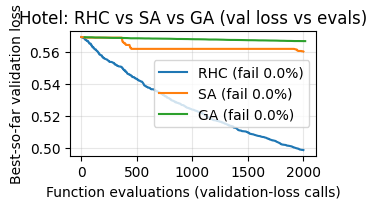

Saved: ro_progress_hotel.png and ro_progress_hotel.pdf


In [43]:
import matplotlib.pyplot as plt

# With Failure Rates, tyr to run this. Then, look into pickles.
def plot_and_save_ro_progress(rhc_res, sa_res, ga_res,
                              title="Part 1: RO progress (val loss vs evals)",
                              png_path="ro_progress.png",
                              pdf_path="ro_progress.pdf"):
    plt.figure(figsize=(3.4, 2.2))
    for name, res in [("RHC", rhc_res), ("SA", sa_res), ("GA", ga_res)]:
        if "history" not in res or not res["history"]:
            continue
        xs = [e for e, _ in res["history"]]
        ys = [b for _, b in res["history"]]
        # compute failure rate if available; else show "n/a"
        if "failures" in res and "evals" in res and res["evals"] > 0:
            fr = res["failures"] / max(1, res["evals"])
            label = f"{name} (fail {fr:.1%})"
        else:
            label = f"{name} (fail n/a)"
        plt.plot(xs, ys, label=label)

    plt.xlabel("Function evaluations (validation-loss calls)")
    plt.ylabel("Best-so-far validation loss")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path,          bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path} and {pdf_path}")

plot_and_save_ro_progress(rhc_res, sa_res, ga_res,
                          title="Hotel: RHC vs SA vs GA (val loss vs evals)",
                          png_path="ro_progress_hotel.png",
                          pdf_path="ro_progress_hotel.pdf")


In [ ]:
import numpy as np, matplotlib.pyplot as plt, pickle

# ---- picked configs from your screenshot ----
picked_rhc_cfg = {"sigma":0.01, "restarts":0, "budget":2000, "seed":42}
picked_sa_cfg  = {"sigma":0.01, "T0":5.0, "decay":0.995, "budget":2000, "seed":42}
picked_ga_cfg  = {"pop_size":32, "elite_frac":0.125, "mut_rate":0.05,
                  "sigma":0.005, "generations":2000//32, "seed":42}

with open("picked_cfgs.pkl","wb") as f:
    pickle.dump({"RHC":picked_rhc_cfg,"SA":picked_sa_cfg,"GA":picked_ga_cfg}, f)

# ---- multi-seed median±IQR plot, saved at 300 dpi ----
N_SEEDS, SEEDS = 5, list(range(42, 42+5))
S0 = tail_to_vector(model, k).clone()
XS = np.arange(0, 2001, 10)

run_rhc = lambda s: rhc(model,k,val_loader,start_vec=S0.clone(), **{**picked_rhc_cfg,"seed":s})
run_sa  = lambda s: sa (model,k,val_loader,start_vec=S0.clone(), **{**picked_sa_cfg, "seed":s})
run_ga  = lambda s: ga (model,k,val_loader,start_vec=S0.clone(), **{**picked_ga_cfg, "seed":s})

def agg(run):
    Ys, fr = [], []
    for s in SEEDS:
        res = run(s); h = np.array(res["history"]); x,y = h[:,0],h[:,1]
        Ys.append(np.interp(XS, x, y, left=y[0], right=y[-1]))
        fr.append(res.get("failures",0)/max(1,res.get("evals",len(x))))
    Y = np.vstack(Ys)
    return np.median(Y,0), np.percentile(Y,25,0), np.percentile(Y,75,0), np.mean(fr)

plt.figure(figsize=(3.8,2.4))
for name, run in [("RHC",run_rhc),("SA",run_sa),("GA",run_ga)]:
    med,q1,q3,fr = agg(run)
    plt.plot(XS, med, label=f"{name} (fail {fr:.1%})"); plt.fill_between(XS,q1,q3,alpha=0.2)
plt.xlabel("Function evaluations"); plt.ylabel("Best-so-far val loss")
plt.title("RO trajectories: median ± IQR over seeds"); plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig("ro_trajectories.png", dpi=300, bbox_inches="tight")
plt.savefig("ro_trajectories.pdf", bbox_inches="tight"); plt.show()
print("Saved configs → picked_cfgs.pkl; plots → ro_trajectories.(png/pdf)")
